### Preliminary research
##### Energy datasets
 - [Data miner 2](https://dataminer2.pjm.com/list) from PJM (Pennsylvania, Jersey, Maryland) Interconnection - responsible for energy balancing and routing in the northeast
 - Solar farm in illinois that supposedly has hourly data according to [this guy](https://github.com/ColasGael/Machine-Learning-for-Solar-Energy-Prediction)

##### Similar thing in Germany:
 - ML [coding project](https://medium.com/hugo-ferreiras-blog/predicting-wind-and-solar-generation-from-weather-data-using-machine-learning-998d7db8415e)
 - Uses this [dataset](https://data.open-power-system-data.org/time_series/)

##### Other stuff
 - Universal [resource](https://openei.org/datasets/dataset?_tags_limit=0) for all things energy related
 - Report talking about [wind power](https://www.nrel.gov/docs/fy14osti/61714.pdf)

### Final Dataset from [IESO](http://www.ieso.ca/en/Power-Data/Data-Directory) (Independent Electricity System Operator) - Ontario, Canada:
 - data [here](http://reports.ieso.ca/public/GenOutputCapability/PUB_GenOutputCapability.xml)
 - estimate station locations from [here](http://www.ieso.ca/localContent/ontarioenergymap/index.html)
 - also a list of stations on [wikipedia](https://en.wikipedia.org/wiki/List_of_generating_stations_in_Ontario)

In [1]:
# import libraries and magic
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import re
import geopandas
import requests
import glob
from IPython.display import display

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.rcParams.update({'font.size': 14})

year = 2015

In [2]:
# import station locations to DataFrame
sloc_df = pd.read_csv('ieso_locations.csv')
print(len(sloc_df))
display(sloc_df.head())

60


,latitude,longitude,station_name,station_type,station_alt_name,in_dataset
0,43.100099,-81.634304,ADELAIDE,Wind,NaN,1
1,44.104724,-80.618731,AMARANTH,Wind,NaN,1
2,44.136418,-76.736188,AMHERST ISLAND,Wind,NaN,1
3,44.228352,-81.429660,ARMOW,Wind,NaN,1
4,42.293120,-82.712032,BELLE RIVER,Wind,NaN,1


In [3]:
true_sloc_df = sloc_df.loc[sloc_df['in_dataset']==1]
print(len(true_sloc_df))
display(true_sloc_df.head())

50


,latitude,longitude,station_name,station_type,station_alt_name,in_dataset
0,43.100099,-81.634304,ADELAIDE,Wind,NaN,1
1,44.104724,-80.618731,AMARANTH,Wind,NaN,1
2,44.136418,-76.736188,AMHERST ISLAND,Wind,NaN,1
3,44.228352,-81.429660,ARMOW,Wind,NaN,1
4,42.293120,-82.712032,BELLE RIVER,Wind,NaN,1


In [4]:
# method to create hour, date, datetime (date + hour) columns in energy dataframes
def concat_dt(df):
    # temporarily split date into three columns & append to existing df
    display(df['Date'].head())
    tmp = df['Date'].str.split('-', expand=True)
    tmp.columns = ['day','month','year']
    tmp.loc[:,'day'] = tmp['day']
    df = pd.concat([df, tmp], sort=False, axis=1)
    
    # zero-pad days and hours
    df.loc[:,'day'] = df['day'].astype('int').apply(lambda x: '{0:02d}'.format(x))
    df.loc[:,'hour'] = (df['Hour'].astype('int') - 1).apply(lambda x: '{0:02d}'.format(x))
    
    # create date and datetime columns
    df.loc[:,'date'] = \
        df['year'].astype('str') + '-' +\
        df['month'].astype('str') + '-' +\
        df['day'].astype('str')
    df.loc[:,'datetime'] = df['date'].astype('str') + '-' + df['hour'].astype('str')
    
    # convert to datetimeobjects
    df.loc[:,'date'] = pd.to_datetime(df['date'], format='%y-%b-%d')
    df.loc[:,'datetime'] = pd.to_datetime(df['datetime'], format='%y-%b-%d-%H')
    
    # drop miscelaneous columns we don't need
    df.drop(['Date','Hour','year', 'month', 'day'], axis=1, inplace=True)
    
    # convert hour back to integer
    df.loc[:,'hour'] = df['hour'].astype('int')
    return df

In [5]:
# import station data (output, capabilites, available capacities) to DataFrames
otpt_df = pd.read_csv('GOC-' + str(year) + '-output.csv')
otpt_df = concat_dt(otpt_df)
capa_df = pd.read_csv('GOC-' + str(year) + '-capabilities.csv')
capa_df = concat_dt(capa_df)
avca_df = pd.read_csv('GOC-' + str(year) + '-available-capacities.csv')
avca_df = concat_dt(avca_df)

0    1-Jan-15
1    1-Jan-15
2    1-Jan-15
3    1-Jan-15
4    1-Jan-15
Name: Date, dtype: object

0    1-Jan-15
1    1-Jan-15
2    1-Jan-15
3    1-Jan-15
4    1-Jan-15
Name: Date, dtype: object

0    1-Jan-15
1    1-Jan-15
2    1-Jan-15
3    1-Jan-15
4    1-Jan-15
Name: Date, dtype: object

In [6]:
print("Station Locations")
display(sloc_df.head())
print("Station Output")
display(otpt_df.head())
print("Station Capabilities")
display(capa_df.head())
print("Station Available Capacities")
display(avca_df.head())

Station Locations


,latitude,longitude,station_name,station_type,station_alt_name,in_dataset
0,43.100099,-81.634304,ADELAIDE,Wind,NaN,1
1,44.104724,-80.618731,AMARANTH,Wind,NaN,1
2,44.136418,-76.736188,AMHERST ISLAND,Wind,NaN,1
3,44.228352,-81.429660,ARMOW,Wind,NaN,1
4,42.293120,-82.712032,BELLE RIVER,Wind,NaN,1


Station Output


,TOTAL,ABKENORA,ADELAIDE,AGUASABON,ALEXANDER,AMARANTH,APIROQUOIS,ARNPRIOR,ATIKOKAN-G1,AUBREYFALLS,...,WELLS,WESTWINDSOR,WHITBYCGS,WHITEDOG,WOLFE ISLAND,YORKCGS-G1,YORKCGS-G2,hour,date,datetime
0,18218,13,58,0,65,172,77,0,0,63,...,0,131,57,37,154,0,0,0,2015-01-01,2015-01-01 00:00:00
1,17888,13,57,0,65,171,77,0,0,64,...,0,131,57,22,184,0,0,1,2015-01-01,2015-01-01 01:00:00
2,17603,13,56,0,65,174,77,0,0,2,...,0,131,57,23,183,0,0,2,2015-01-01,2015-01-01 02:00:00
3,17451,13,58,0,65,161,77,0,1,0,...,0,131,57,23,181,0,0,3,2015-01-01,2015-01-01 03:00:00
4,17287,13,58,0,65,150,77,0,0,0,...,0,131,57,40,177,0,0,4,2015-01-01,2015-01-01 04:00:00


Station Capabilities


,ABKENORA,ADELAIDE,AGUASABON,ALEXANDER,AMARANTH,APIROQUOIS,ARNPRIOR,ATIKOKAN-G1,AUBREYFALLS,BARRETT,...,WELLS,WESTWINDSOR,WHITBYCGS,WHITEDOG,WOLFE ISLAND,YORKCGS-G1,YORKCGS-G2,hour,date,datetime
0,13,57,22,68,170,70,82,205,164,179,...,221,128,56,68,152,219,219,0,2015-01-01,2015-01-01 00:00:00
1,13,57,22,68,168,70,82,205,164,179,...,221,128,56,68,182,219,219,1,2015-01-01,2015-01-01 01:00:00
2,13,55,22,68,171,70,82,205,164,179,...,221,128,56,68,183,219,219,2,2015-01-01,2015-01-01 02:00:00
3,13,57,22,68,163,70,82,205,164,179,...,221,128,56,68,179,219,219,3,2015-01-01,2015-01-01 03:00:00
4,13,58,22,68,147,70,82,205,164,179,...,221,128,56,68,176,219,219,4,2015-01-01,2015-01-01 04:00:00


Station Available Capacities


,ABKENORA,ADELAIDE,AGUASABON,ALEXANDER,AMARANTH,APIROQUOIS,ARNPRIOR,ATIKOKAN-G1,AUBREYFALLS,BARRETT,...,WELLS,WESTWINDSOR,WHITBYCGS,WHITEDOG,WOLFE ISLAND,YORKCGS-G1,YORKCGS-G2,hour,date,datetime
0,13,58,22,68,200,70,82,205,164,179,...,221,128,56,68,198,219,219,0,2015-01-01,2015-01-01 00:00:00
1,13,57,22,68,200,70,82,205,164,179,...,221,128,56,68,198,219,219,1,2015-01-01,2015-01-01 01:00:00
2,13,56,22,68,200,70,82,205,164,179,...,221,128,56,68,198,219,219,2,2015-01-01,2015-01-01 02:00:00
3,13,58,22,68,200,70,82,205,164,179,...,221,128,56,68,198,219,219,3,2015-01-01,2015-01-01 03:00:00
4,13,58,22,68,200,70,82,205,164,179,...,221,128,56,68,198,219,219,4,2015-01-01,2015-01-01 04:00:00


In [7]:
# Extract names of wind stations for which we have data
wind_station_names = sloc_df.loc[sloc_df['station_type']=='Wind','station_name']
wind_station_names = list(wind_station_names)
print(len(wind_station_names),'wind farms in Ontario to analyze')

# Filter down to just wind stations in otpt_df
newcols = ['hour','date','datetime'] + wind_station_names
wind_otpt_df = otpt_df.loc[:,newcols]
wind_pred_df = capa_df.loc[:,newcols]
wind_mxop_df = avca_df.loc[:,newcols]

# Melt so that there are only "station_name" and "power_output" columns rather than one column per station
melted_wind_otpt_df = pd.melt(wind_otpt_df, id_vars=["hour", "date", "datetime"], var_name="station_name", value_name="power_output")                                
melted_wind_pred_df = pd.melt(wind_pred_df, id_vars=["hour", "date", "datetime"], var_name="station_name", value_name="pred_power_output")                                
melted_wind_mxop_df = pd.melt(wind_mxop_df, id_vars=["hour", "date", "datetime"], var_name="station_name", value_name="max_power_output")                                

# Add (1) predicted power gen and (2) % max for wind_otpt to final wind df
melted_wind_otpt_df.loc[:,'pred_power_output'] = melted_wind_pred_df['pred_power_output']
melted_wind_otpt_df.loc[:,'max_power_output'] = melted_wind_mxop_df['max_power_output']
melted_wind_otpt_df.loc[:,'pmax_power_output'] = melted_wind_otpt_df['power_output']/melted_wind_otpt_df['max_power_output']
melted_wind_otpt_df.loc[:,'pred_pmax_power_output'] = melted_wind_otpt_df['pred_power_output']/melted_wind_otpt_df['max_power_output']

# make sure calcs worked as expected
display(melted_wind_otpt_df.head(5))

48 wind farms in Ontario to analyze


C:\Users\alacroix367\Miniconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,hour,date,datetime,station_name,power_output,pred_power_output,max_power_output,pmax_power_output,pred_pmax_power_output
0,0,2015-01-01,2015-01-01 00:00:00,ADELAIDE,58.0,57.0,58.0,1.0,0.982759
1,1,2015-01-01,2015-01-01 01:00:00,ADELAIDE,57.0,57.0,57.0,1.0,1.000000
2,2,2015-01-01,2015-01-01 02:00:00,ADELAIDE,56.0,55.0,56.0,1.0,0.982143
3,3,2015-01-01,2015-01-01 03:00:00,ADELAIDE,58.0,57.0,58.0,1.0,0.982759
4,4,2015-01-01,2015-01-01 04:00:00,ADELAIDE,58.0,58.0,58.0,1.0,1.000000


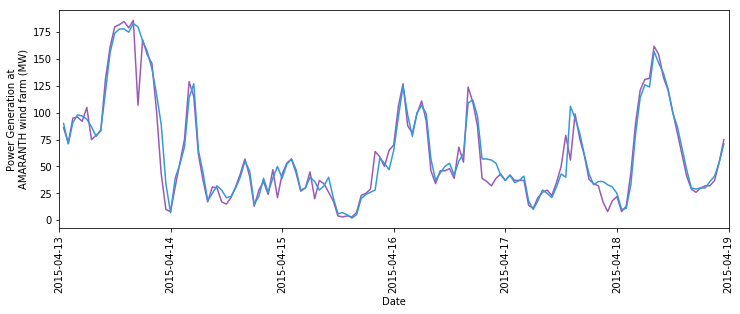

In [8]:
# plot some energy vs time
# visualize hourly wind power generation at station n
# stn = 'ARMOW'
stn = 'AMARANTH'
# stn = 'GREENWICH'
# start_date  = dt.datetime(year, 8, 1)
# end_date = dt.datetime(year, 8, 7)
start_date  = dt.datetime(year, 4, 13)
end_date = dt.datetime(year, 4, 19)

f,ax = plt.subplots(figsize=(12,4))

# data from single station
tmp_wind_otpt_df = melted_wind_otpt_df.loc[
    (melted_wind_otpt_df['datetime']>start_date) & 
    (melted_wind_otpt_df['datetime']<end_date) & 
    (melted_wind_otpt_df['station_name']==stn)]

sns.lineplot(x='datetime', y='power_output', data=tmp_wind_otpt_df, color="#9b59b6")
sns.lineplot(x='datetime', y='pred_power_output', data=tmp_wind_otpt_df, color="#3498db")
ax.set_xlim([start_date,end_date])
plt.xticks(rotation=90)
ax.set_ylabel('Power Generation at\n' + stn + ' wind farm (MW)')
ax.set_xlabel('Date')
plt.show();

In [9]:
# At this point we've got two pieces of information - write them to csv
#    (1) sloc_df = Wind farm locations (and other metadata) - already saved as `ieso_locations.csv`
#    (2) melted_wind_otpt_df = Wind farm power output

true_sloc_df.to_csv('compiled_wind_farm_station_metadata_' + str(year) + '.csv')
melted_wind_otpt_df.to_csv('compiled_wind_power_data_' + str(year) + '.csv')